## **Water Body Image Segmentation from Satellite Imagery: A Computer Vision Study**
---

### **Project Structure**
This project implements a comprehensive approach to water body segmentation from satellite images through three progressive phases:

#### Part 1: Vanilla U-Net Implementation
- Building a U-Net architecture from scratch in PyTorch to develop a fundamental understanding of the model's internal mechanisms and architectural principles.

#### Part 2: Transfer Learning Integration for Pre-trained Models (EfficientNet & U-Net++)
- Leveraging pre-trained models to evaluate performance improvements achieved through more sophisticated and advanced architectures, utilizing EfficientNet as encoder and U-Net++ framework.

#### Part 3: Vision Transformer (ViT) Implementation
- Incorporating Vision Transformer to explore the upper bounds of segmentation performance capabilities on water body segmentation.


---
### **Project Motivation**

The original concept emerged from the need to apply image classification techniques to real-time video streams of water containment structures. The goal was to develop an automated monitoring system capable of detecting overflow and spillage events, providing immediate alerts while reducing manual monitoring requirements.

### **Business Benefits if Implemented**

- **Cost Savings**: Saving hundreds to thousands of man-hours by transitioning from manual monitoring to enhanced automatic monitoring capabilities beyond basic alert systems
- **Infrastructure Efficiency**: Saving hundreds of thousands in budget by utilizing existing camera systems instead of installing advanced monitoring hardware
- **Analytics Enhancement**: Quantitative analysis of water coverage and capacity utilization for informed decision-making




> ### Part 1 - Vanilla U-Net Implementation from Scratch with PyTorch

## 1.1 Data Exploration and Preprocessing
The exploration on the satelite imagery includes:
 - **Image Charteristics** : dimension, size and modes of the images (whether it is 'RGB' or 'RBG')

- **Mask Charteristics** : Understanding mask representation formats, including single-channel labeled masks, multi-channel one-hot encoded masks, or alternative encoding schemes

- **Class Distribution** : Checking the raio of water vs non-water pixel ratios across the dataset to understand class balance and potential imbalances
    
- **Data Quality** : General Assessment of annotation quality and potential noise in ground truth mask

In [ ]:
import os 
import numpy as np
from tqdm.auto import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

In [ ]:
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from torch.utils.data import Dataset, DataLoader
from torch.autograd import detect_anomaly
from sklearn.model_selection import train_test_split
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-26 18:38:16.708395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750963096.914131      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750963096.974656      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cuda')

In [ ]:
torch.cuda.empty_cache()

#### 1.1a - Importing training data
This project utilize the image dataset from kagglehub which provide the image and the mask of water boides in satellite images :[satellite images fo water boides](https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

img_folder = path+"/Water Bodies Dataset/Images"
mask_folder = path+"/Water Bodies Dataset/Masks"

images_name = sorted(os.listdir(img_folder))
masks_name = sorted(os.listdir(mask_folder))

# creating a list of links to images and mask
image_files_list  = [os.path.join(img_folder,img_name) for img_name in images_name]
mask_files_list  = [os.path.join(mask_folder,mask_name) for mask_name in masks_name]

Path to dataset files: /kaggle/input/satellite-images-of-water-bodies


##### 1.1b- Basic data exploratory

In [ ]:
#checking the images mode and size
img = Image.open(image_files_list[15])
img.mode , img.size

('RGB', (150, 231))

In [ ]:
# checking the mask image mode and size
mask = Image.open(mask_files_list[15])
mask.mode , mask.size

('RGB', (150, 231))

> The mask images are currently in RGB format rather than single-channel grayscale or labeled tensors, requiring conversion to a single-layer tensor format. <br> Transformation involving using Pillow's image.convert('L') method to convert to grayscale, then dividing the single-channel pixel values by 255.0 and applying round() to produce categorical labels is required

#### 1.1.2 Plotting random images and their masks to sense check the images and masks

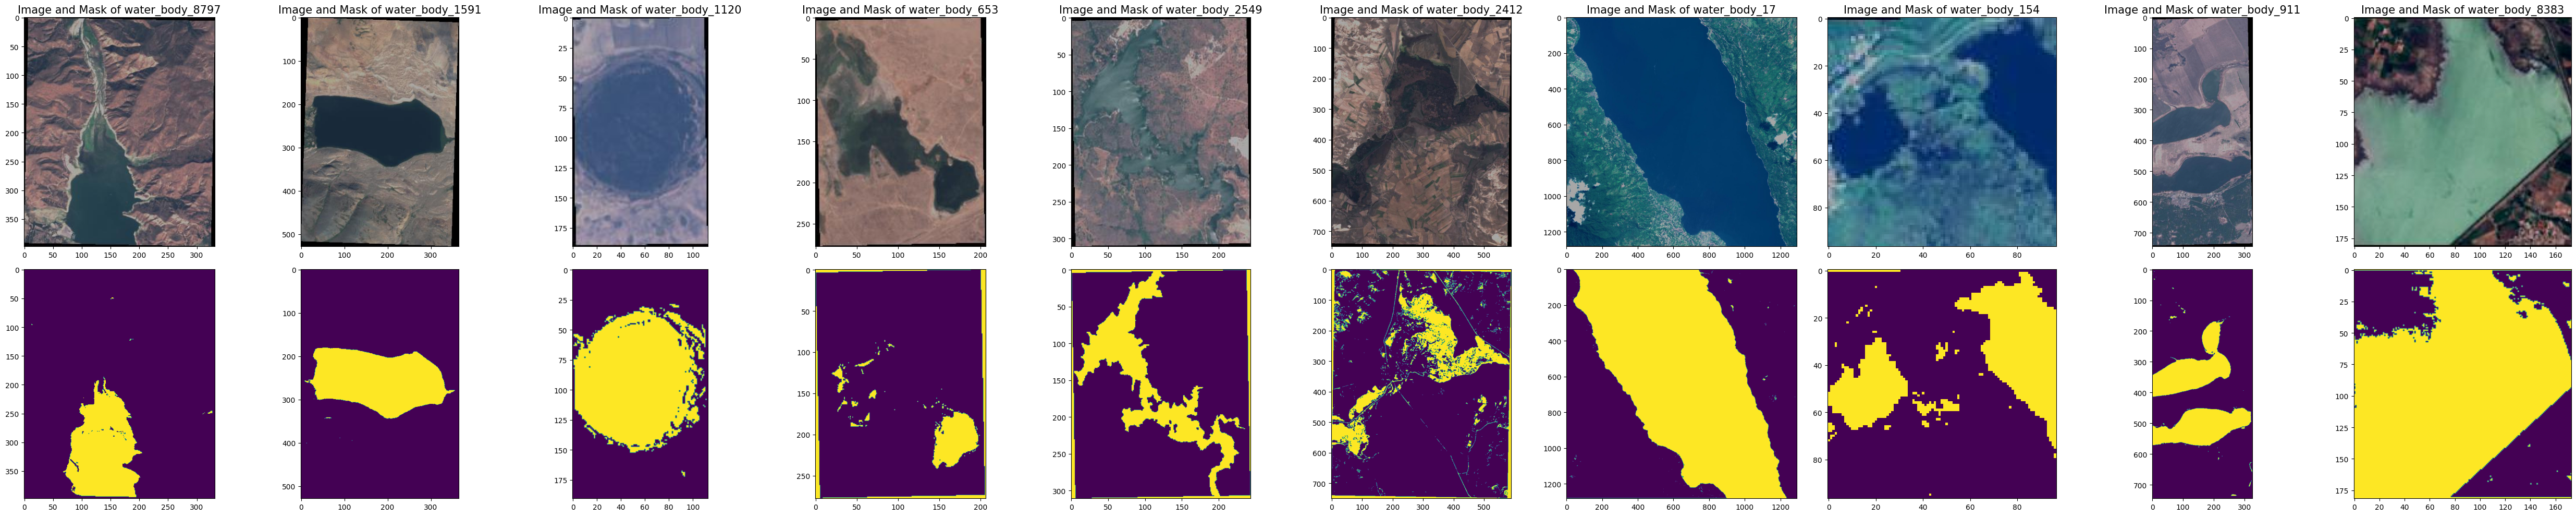

In [ ]:
# plotting 10 random images and masks
fig,axs = plt.subplots(2,10, figsize= (50,10))
ax = axs.flatten()
random.seed(42)

for i,j in zip(range(10),random.sample(range(len(image_files_list)),k=10)):
    ax[i].set_title(f'Image and Mask of {image_files_list[j].split("/")[-1][:-4]}', fontsize=15)
    ax[i].imshow(np.array(Image.open(image_files_list[j])))
    
    # applying transformation to the mask files to one channel files with values 0 or 1 as label
    ax[i+10].imshow(np.round(np.array(Image.open(mask_files_list[j]).convert('L'))/255.0))
    
plt.tight_layout()
plt.show()



> There is some issue with data annotation:  when the shape of image is not rectangular , the edges are randomly shown as water bodies or ground in the images, which could increase the error during the learning.
> - (see images water_body_1591 (2nd column) and water_body_653 (4th column) 

> One potential solution involves applying a threshold based on mean RGB values below a certain level, but this approach proves ineffective since the edges appear grey-blackish rather than pure black. Given that this could introduce additional annotation noise, a more straightforward approach is to crop and retain only the central 90% of each image during transformation, thereby reducing noise in the dataset.

A demo of using a threshold to distinguish the edges in the image is shwon below:


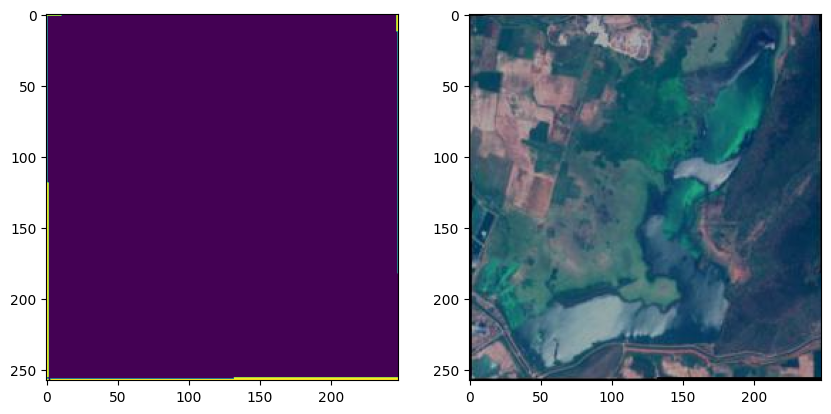

In [ ]:
edge_threshold = 0.09
fig,ax = plt.subplots(1,2, figsize= (4,3))
ax = ax.flatten()
ax[0].imshow(np.array(Image.open(image_files_list[1728])).mean(axis=2)/255.0<edge_threshold)
ax[1].imshow(np.array(Image.open(image_files_list[1728])))

## 1.2 - Data Preprocessing
- **Resizing** : creating uniform image dimensions as model input
- **Normalization** : Normalising the pixel values between 0 and 1 for stable training
- **Dataset Class** : Setting up dataset class to access and transform data samples and labels 
- **Train-Validation Split** : Splitting the dataset for model validation and testing

In [ ]:
# The images and masks are resized to 256x256 pixels and normalized to have pixel values between 0 and 1.

transform= A.Compose([
    # resizing to (256*1.05 = 282) *282 image and apply centre crop to 256 for removing the unwanted edges
    A.Resize(282,282,1.0),
    A.CenterCrop(height=256,width=256,p=1.0),

    # applying random horiztonal flipping 
    A.HorizontalFlip(p=0.5),
    
    # other approaches for creating synthetic data 
    # transforms.ColorJitter(brightness=0.2,contrast=0.2),
    # transforms.RandomAffine(degrees=15, scale=(0.95,1.05), translate=(0.05,0.05)),

    # A.normalize input is (height,width,3) for RGB and (height,width,1) for greyscale
    # different from torchvision.transforms.functional.noramlize()
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.ToTensorV2()
    
])

In [ ]:
#creating dataset class

class WaterDataset(Dataset):
    def __init__ (self, img_list, mask_list, transform= None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path, mask_path  = self.img_list[idx] , self.mask_list[idx]

        img = np.array(Image.open(image_path),dtype=np.float32)
        img = img/255.0 

        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)
        mask = mask/255.0
        
        # print(img.shape, mask.shape)
        if self.transform :
            transformed  = self.transform(image=img,mask = mask)
            img = transformed['image']
            mask = torch.round(transformed['mask'])

        else:
            
            img , mask = torch.tensor(img).permute(2,0,1),torch.round(torch.tensor(mask))
            img = torchvision.transforms.functional.normalize(img,(0.5,0.5,0.5),(0.5,0.5,0.5))
        
        mask=mask.unsqueeze(0)
        return img, mask


            

In [ ]:
#Train-Validation Split
X_train , X_val , y_train, y_val = train_test_split(image_files_list, mask_files_list,test_size = 0.2 , random_state=42)

In [ ]:
# Creating dataset and dataloader
train_dataset = WaterDataset (X_train,y_train,transform=transform)
test_dataset = WaterDataset (X_val,y_val,transform = transform)

train_loader = DataLoader(train_dataset,batch_size= 32 , num_workers = 4 , shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32 , num_workers =4 , shuffle = True)


In [ ]:
# checking the shapes of the tensors
check_img , check_mask = train_dataset[2]
check_img.shape, check_mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

## 2.1 Constructing the Unet backbones and blocks from Scratch
The U-net design consists of three major components: Encoder (Contracting Path), Decoder (Expanding Path) and skip Connections between them
<br> The Encoder is composed of : 
- 2 convolutional layers with Batch Normalization (Padding is added as opposed to the original paper for simplicity)
- LeakyRelu layer (the original paper used Relu but LeakyRelu is used here for better gradient flow)
- Downsampling : Max pooling operations

<br> The Decoder is composed of :
- Upsampling layer (Transposed convolution)
- Skip connections and feature fusion
- Convolution layer for channel reduction
<br> The output is connected to a 1-channel convolution layer for pixel-wise classification

Image extracted from the paper  **U-Net: Convolutional Networks for Biomedical**
Image Segmentation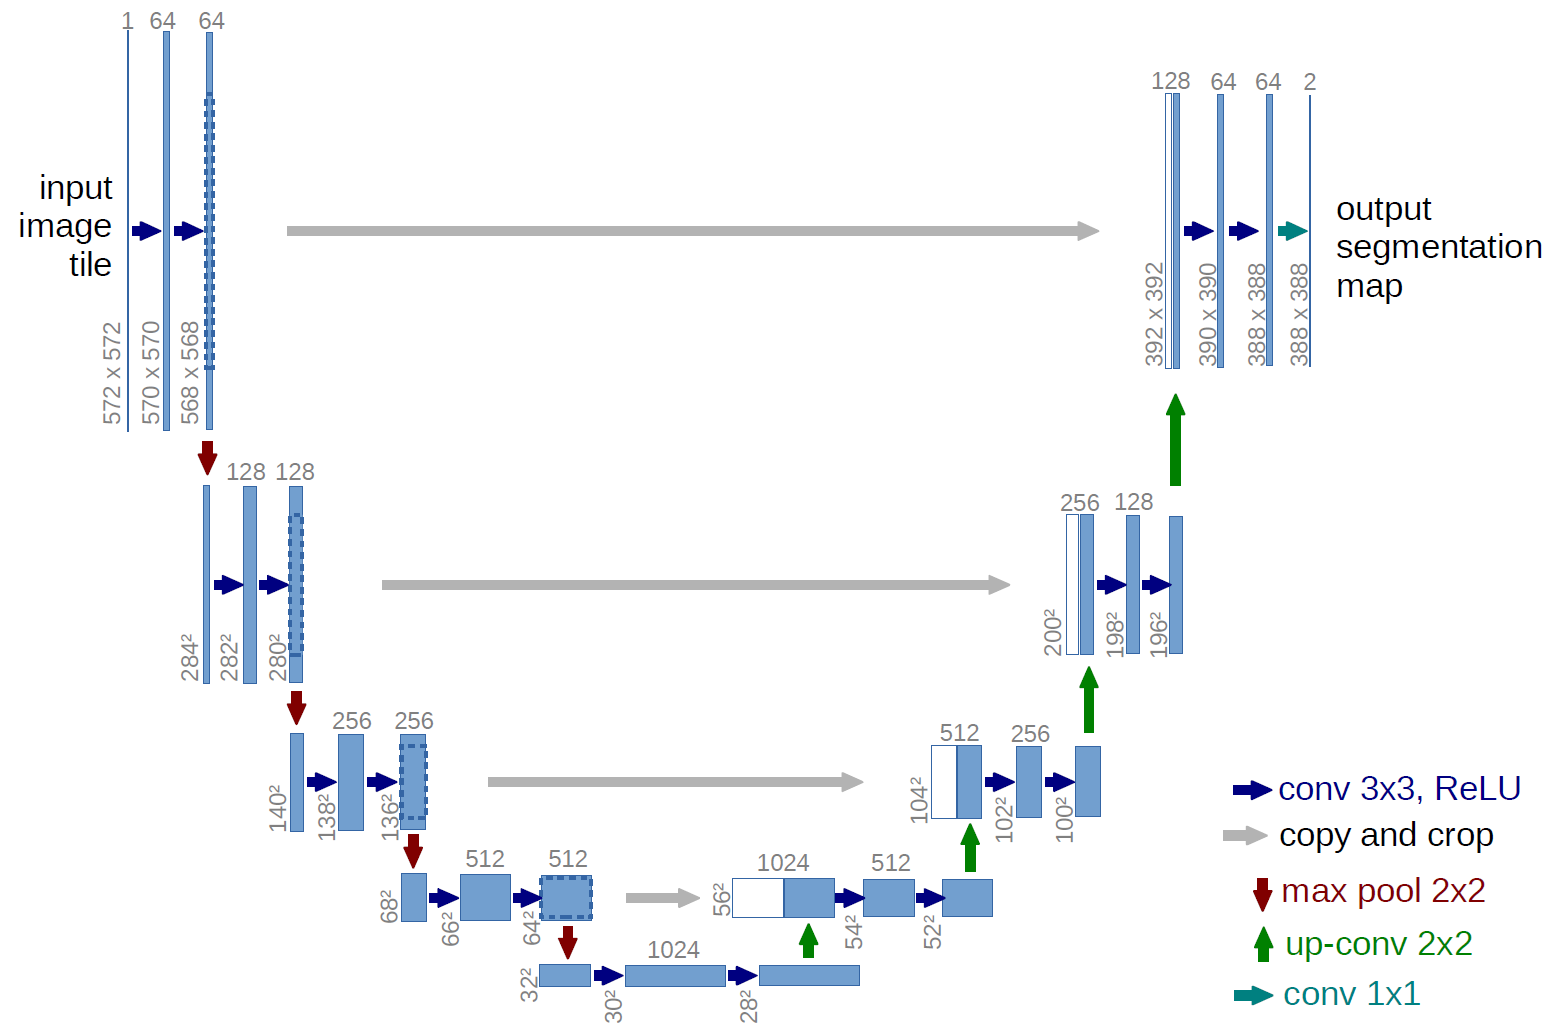

In [ ]:
from torch import nn

# the horiztonal block ie. the convolutional block
class horizontal (nn.Module):
    def __init__ (self, channel_in, channel_out):
        super().__init__()
        # ouput_size = [(input_size -kennel_size +2* padding)/ stride] +1
        self.conv = nn.Sequential(
            # padding is created as opposed to the original paper to simplified the calculation
            nn.Conv2d(channel_in,channel_out,3,padding=1),
            nn.BatchNorm2d(channel_out),
            
            # padding is created as opposed to the original paper to simplified the calculation
            nn.Conv2d(channel_out,channel_out,3,padding=1),
            nn.BatchNorm2d(channel_out),
            
            # LeakyReLU was used to help with Vanishing Gradient 
            nn.LeakyReLU(negative_slope=0.01)
            # nn.ReLU(inplace=True)
        )

    def forward (self, x):
        return self.conv(x)
        
# the downsampling block
class downward (nn.Module):
    def __init__ (self, channel_in , channel_out):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            horizontal(channel_in,channel_out)
        )
    
    def forward (self,x):
        return self.down(x)

# the upsampling block
class upward (nn.Module):
    def __init__ (self, channel_in,channel_out):
        super().__init__()
        # output = stride * (input_size -1) + Kernel_size() - 2*padding
        self.up = nn.ConvTranspose2d(channel_in, channel_in //2 , 2, stride =2)
        self.horizontal = horizontal(channel_in,channel_out)

    def forward(self,x1, x2):
        x1 = self.up(x1)
        # diff_y = x2.size()[2] - x1.size()[2]
        # diff_x = x2.size()[3] - x1.size()[3]
        # x1 = torch.nn.functional.pad(x1,[diff_x//2, diff_x -diff_x//2 , diff_y//2, diff_y-diff_y//2])
        x2 = torch.cat([x2,x1], dim=1)

        return self.horizontal(x2)

# the transpose convolutional block
class OutputMap (nn.Module):
    def __init__(self, channel_in,channel_out):
        super().__init__()
        self.out = nn.Sequential(
            nn.Conv2d(channel_in,channel_out,1)
            # output is logit for better loss calculation
        )

    def forward(self,x):
        return self.out(x)

# The backbone of the Unet
class UNet (nn.Module):
    def __init__ (self, n_channels , n_classes):
        super().__init__()
        self.horizontal1 = horizontal(n_channels,64)
        self.down1 = downward(64,128)
        self.down2 = downward(128,256)
        self.down3 = downward(256,512)
        self.down4 = downward(512,1024)
        self.up1 = upward(1024,512)
        self.up2 = upward(512,256)
        self.up3 = upward(256,128)
        self.up4 = upward(128,64)
        self.outc = OutputMap (64, n_classes)

    def forward(self,x):
        x1 = self.horizontal1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        logits = self.outc(x)

        return logits

In [17]:
# printing the summary to check for error
from torchsummary import summary
model = UNet(3,1).to(device)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
         LeakyReLU-5         [-1, 64, 256, 256]               0
        horizontal-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
       horizontal-13        [-1, 128, 128, 128]               0
         downward-14        [-1, 128, 1

### 2.2 Loss function 
**Combination of BCE loss and DICE loss is used for the loss function**
<br>
- BCE is effective for pixel-wise classification, it treats each pixel independently and doesn't account for class imbalance while DICE loss is similar to F1 score which penalise much more when there is any one class performing badly, hence handling hte class imbalance . The combination of two helps leading to a better segemntation quality.
- The weight for BCE loss and DICE loss are referenced from the paper 
    [Loss Functions in the Era of Semantic Segmentation](https://arxiv.org/abs/2312.05391)

In [18]:
# Using the sum of DiceLoss and BCELoss as the Loss function

#dice_loss
def dice_loss (pred,target,epsilon=1e-6):

    pred = torch.sigmoid(pred)
       
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)
    return 1 - dice

#Creating combinedLoss 
class CombinedLoss(nn.Module):
    def __init__(self,bce_weight=0.6,beta=0.7):
        super().__init__()

        self.bce_loss= nn.BCEWithLogitsLoss()
        # self.bce_loss= nn.BCELoss()

        self.bce_weight = bce_weight
    
    def forward(self,logits,targets,return_individual=True):
        
        dice = dice_loss(logits,targets)
        
        bce = self.bce_loss(logits,targets)
        # iou = jaccard_loss(logits,targets)
        combined = (1-self.bce_weight)*dice + (self.bce_weight)*bce

        if return_individual:
            return combined, dice, bce
        return combined



Function for checking the gradient flow
- This grad flow plot is copied from the pytorch forum [Check gradient flow in network](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063) for visualising the the gradient flow and check against any expanding or vanishing gradient

In [19]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()


### 3.1 Training Process and optimization

In [20]:
## Training Function
def train(model, train_loader, val_loader, optimizer, criterion, epochs,scheduler=None):
    train_losses, val_losses = [], []
    train_dice_losses, val_dice_losses = [], []
    train_bce_losses, val_bce_losses = [], []
    
    # scaler is added for dynamic learning rate
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in tqdm(range(epochs),desc="Epoch",position=0, leave=True):
        
        model.train()
        # resetting the loss for each full batch propagations
        total_training_loss ,total_training_dice ,total_training_bce = 0.0 , 0.0 , 0.0
        
        for  images, masks in tqdm(train_loader,desc="training_batch",position=1, leave=True):
            
            images , masks = images.to(device) , masks.to(device)        

            optimizer.zero_grad() 
            with torch.amp.autocast('cuda'):
                output = model(images)
                total_loss, dice_component, bce_component = criterion(output, masks, return_individual=True)
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ### added to check if there is any nan or exploding gradient
            # with detect_anomaly():
            # logits = model(images)
            # loss  = criterion(logits,masks)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            
            total_training_loss += total_loss.item()
            total_training_dice += dice_component.item()
            total_training_bce += bce_component.item()
            
        # plotting images, mask and predictions every 5 epoch
        if epoch %5 ==0:
            plot_sample_images(images,masks,model,epoch)
                      
        # gradient flow and check for vanishing gradient at the 2nd epoch
        # if epoch ==2:
        #     plot_grad_flow(model.named_parameters())  
        
        # Calculate and append training loss each epoch
        train_loss_this_epoch = total_training_loss / len(train_loader)
        train_dice_this_epoch = total_training_dice / len(train_loader)
        train_bce_this_epoch = total_training_bce / len(train_loader)
        
        train_losses.append(train_loss_this_epoch)
        train_dice_losses.append(train_dice_this_epoch)
        train_bce_losses.append(train_bce_this_epoch)
        # writer.add_scalar("Loss/train", train_loss_this_epoch, epoch)

        if scheduler is not None:
            scheduler.step()
        
        model.eval()
        total_val_loss, total_val_dice, total_val_bce  = 0.0 , 0.0, 0.0
        
        with torch.no_grad():
            for images,masks in tqdm(val_loader,desc="val_batch",position=2, leave=True):
                images, masks = images.to(device) , masks.to(device)
                
                logits = model(images)
                total_loss, dice_component, bce_component = criterion(logits, masks, return_individual=True)
                
                total_val_loss += total_loss.item()
                total_val_dice += dice_component.item()
                total_val_bce += bce_component.item()
                
        if epoch %5 ==0:
            plot_sample_images(images,masks,model,epoch)

        # Calculate and append validation loss each epoch
        val_loss_this_epoch = total_val_loss / len(val_loader)
        val_dice_this_epoch = total_val_dice / len(val_loader)
        val_bce_this_epoch = total_val_bce / len(val_loader)
        
        val_losses.append(val_loss_this_epoch)
        val_dice_losses.append(val_dice_this_epoch)
        val_bce_losses.append(val_bce_this_epoch)

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'  Train - Total: {train_loss_this_epoch:.4f}, Dice: {train_dice_this_epoch:.4f}, BCE: {train_bce_this_epoch:.4f}')
        print(f'  Val   - Total: {val_loss_this_epoch:.4f}, Dice: {val_dice_this_epoch:.4f}, BCE: {val_bce_this_epoch:.4f}')
        print('-' * 80)
        
    return [train_losses , train_dice_losses,train_bce_losses], [val_losses ,val_dice_losses,val_bce_losses]


In [21]:
# definition for plotting the image , mask and predictions
def plot_sample_images(images,masks,model,epoch):
    fig, axes = plt.subplots(1, 3, figsize=(5, 3))
    # fig.suptitle(f'Epoch {epoch + 1} - Detailed Predictions', fontsize=16)
    
    ax=axes.flatten()
    img_np = images[3].cpu().permute(1,2,0)
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img_np = img_np * std + mean
    
    mask_np = masks[3].cpu().permute(1,2,0)
    
    with torch.no_grad():
        logits = model(images[3].cpu().unsqueeze(0))
        prediction = torch.sigmoid(logits[0])
        #setting threshold as 0.5
        prediction=(prediction > 0.5)*1.0
    
    
    ax[0].imshow(img_np*255.0)
    ax[0].set_title('Original Images')
    ax[1].imshow(mask_np*255.0, cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(prediction.permute(1,2,0).cpu().numpy()*255.0)
    ax[2].set_title('Model Prediction')

    plt.tight_layout()
    plt.show()

In [22]:
''' Forward hook for testing if the output is correct'''
model = UNet(3,1).to(device)

# forward hook testing
def hook_fn(module , input, output):
    print(f"Layer : {module} , Output Shape: {output.shape}")

for layer in model.children():
    layer.register_forward_hook(hook_fn)

dummy_input = torch.randn(3,3,256,256).to(device)
model(dummy_input)

Layer : horizontal(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
) , Output Shape: torch.Size([3, 64, 256, 256])
Layer : downward(
  (down): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): horizontal(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyR

tensor([[[[-1.0634e-01, -1.2628e-01,  5.7714e-03,  ...,  7.9849e-02,
           -7.8439e-02,  1.3021e-01],
          [ 2.0631e-01,  4.3113e-02,  3.7806e-01,  ..., -3.3594e-01,
           -4.4600e-01,  1.2862e-01],
          [-2.8807e-02, -2.1256e-01, -2.1673e-01,  ..., -3.2809e-01,
           -1.5256e-01, -1.9364e-01],
          ...,
          [ 2.0965e-01, -2.2239e-01,  1.6744e-01,  ..., -4.4616e-02,
           -3.1809e-01, -6.8039e-02],
          [ 1.1023e-01, -2.2672e-01,  8.4620e-02,  ..., -2.9495e-01,
            8.0391e-02, -5.1247e-03],
          [-3.6406e-01, -3.4765e-02, -9.2256e-02,  ...,  1.9107e-01,
           -1.6643e-01,  3.9095e-02]]],


        [[[-2.0052e-01, -3.5448e-01, -2.1101e-01,  ...,  8.4406e-02,
           -1.2533e-01,  4.0008e-02],
          [-8.4173e-02,  6.1519e-02, -3.3395e-01,  ..., -1.4668e-01,
           -1.0507e-01, -3.5859e-01],
          [-9.5740e-06, -1.5051e-01,  4.9773e-01,  ..., -4.7218e-01,
           -6.1028e-02, -7.8767e-02],
          ...,
   

### 1st trial :speed run to see any error in training the model
- Speed run to see how it goes
- Model getting stuck in suboptimal regions during the first few epochs of training with Adam and the validation error is exploding, which can be due to the learning rate is too large and not scaling down accordingly

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

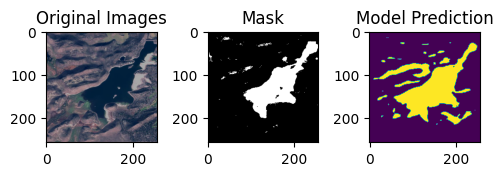

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

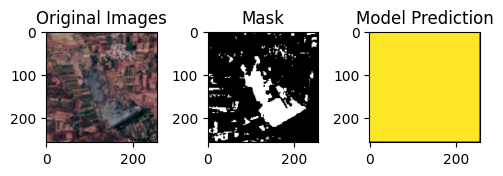

Epoch: 1/10
  Train - Total: 0.4997, Dice: 0.4531, BCE: 0.5308
  Val   - Total: 1.9162, Dice: 0.4944, BCE: 2.8640
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/10
  Train - Total: 0.4402, Dice: 0.3961, BCE: 0.4696
  Val   - Total: 2.2727, Dice: 0.4986, BCE: 3.4554
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

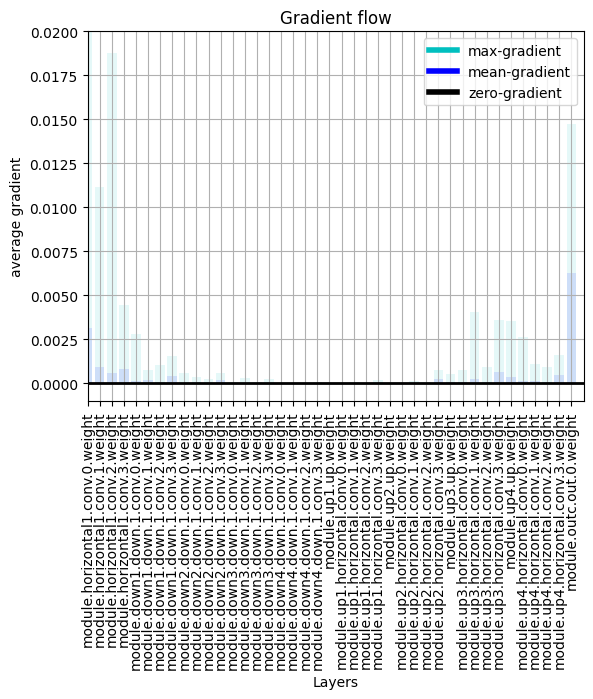

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/10
  Train - Total: 0.4082, Dice: 0.3630, BCE: 0.4383
  Val   - Total: 0.6809, Dice: 0.6747, BCE: 0.6851
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/10
  Train - Total: 0.3854, Dice: 0.3431, BCE: 0.4136
  Val   - Total: 3.5880, Dice: 0.4981, BCE: 5.6479
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/10
  Train - Total: 0.3703, Dice: 0.3252, BCE: 0.4004
  Val   - Total: 23.3339, Dice: 0.4985, BCE: 38.5575
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

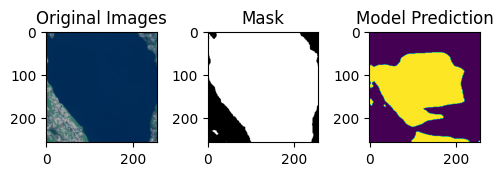

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

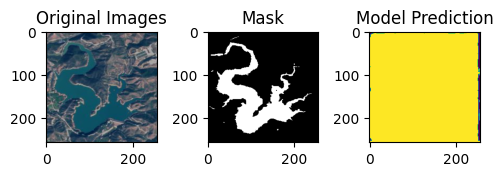

Epoch: 6/10
  Train - Total: 0.3599, Dice: 0.3145, BCE: 0.3902
  Val   - Total: 2.5132, Dice: 0.4923, BCE: 3.8605
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/10
  Train - Total: 0.3612, Dice: 0.3145, BCE: 0.3924
  Val   - Total: 0.7453, Dice: 0.6872, BCE: 0.7840
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/10
  Train - Total: 0.3514, Dice: 0.3043, BCE: 0.3827
  Val   - Total: 0.6875, Dice: 0.6770, BCE: 0.6944
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/10
  Train - Total: 0.3514, Dice: 0.3064, BCE: 0.3814
  Val   - Total: 1.2385, Dice: 0.7243, BCE: 1.5814
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/10
  Train - Total: 0.3350, Dice: 0.2899, BCE: 0.3651
  Val   - Total: 7.4613, Dice: 0.4970, BCE: 12.1042
--------------------------------------------------------------------------------


In [ ]:
# initializing the model and allowing for 2 GPU in parallel
model = UNet(3,1)
model = nn.DataParallel(model)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
criterion = CombinedLoss()
epochs = 10

train_losses, val_losses = train(model, train_loader, test_loader, optimizer,criterion,epochs)

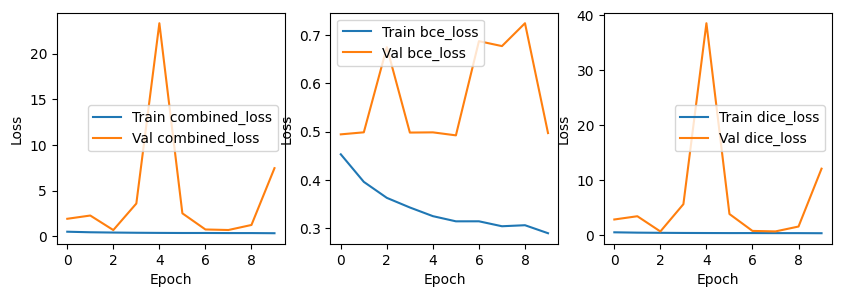

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
ax= axs.flatten()
i=0
for train_losses,val_losses, label in zip (train_losses, val_losses,['combined_loss','bce_loss','dice_loss']):
    ax[i].plot(np.arange(epochs), train_losses)
    ax[i].plot(np.arange(epochs), val_losses)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend([f"Train {label}", f"Val {label}"])
    i+=1
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_1st_trail.pth')
del model
del optimizer
del criterion

In [ ]:
import gc
gc.collect() 

27074

In [ ]:
# clearing the cache in GPUs
torch.cuda.empty_cache()

### Model training with adjusted strategy
### Changes included :
1. **Weight Initialization** : Using Kaiming Initilization for better intialization of weight for leaky relu and BatchNorm which can help with faster training
2. **Reducing Initial Learning Rate** : Reducing the learning rate from 0.001 to 0.0001
3. **Using AdamW Optimizer** : Using AdamW for better weight decay and optimization
4. **Adding LR scheduler** :Using Learning Rate step scheduler to reducing the learning rate in later epochs

(The training epochs was tested to shown improvement before being changed to 30 instead of 10) 

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

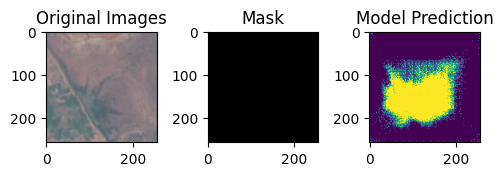

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

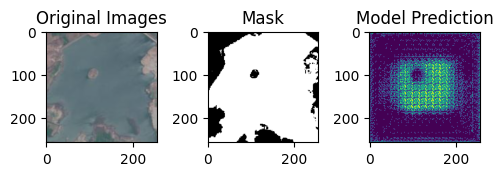

Epoch: 1/30
  Train - Total: 0.6328, Dice: 0.5147, BCE: 0.7116
  Val   - Total: 0.5609, Dice: 0.5486, BCE: 0.5690
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/30
  Train - Total: 0.4459, Dice: 0.4020, BCE: 0.4753
  Val   - Total: 0.6556, Dice: 0.6470, BCE: 0.6613
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/30
  Train - Total: 0.4091, Dice: 0.3593, BCE: 0.4423
  Val   - Total: 2.1431, Dice: 0.4885, BCE: 3.2462
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/30
  Train - Total: 0.3924, Dice: 0.3443, BCE: 0.4244
  Val   - Total: 2.4553, Dice: 0.4893, BCE: 3.7659
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/30
  Train - Total: 0.3794, Dice: 0.3303, BCE: 0.4122
  Val   - Total: 0.5371, Dice: 0.3514, BCE: 0.6609
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

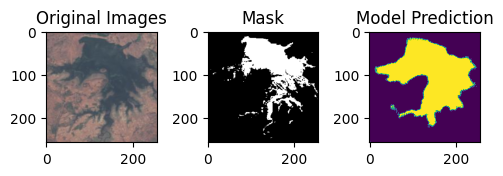

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

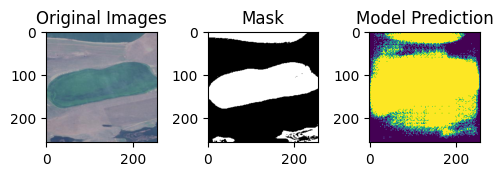

Epoch: 6/30
  Train - Total: 0.3738, Dice: 0.3243, BCE: 0.4068
  Val   - Total: 0.7202, Dice: 0.3808, BCE: 0.9464
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/30
  Train - Total: 0.3624, Dice: 0.3154, BCE: 0.3936
  Val   - Total: 0.4019, Dice: 0.3774, BCE: 0.4183
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/30
  Train - Total: 0.3508, Dice: 0.3027, BCE: 0.3829
  Val   - Total: 0.6047, Dice: 0.5867, BCE: 0.6167
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/30
  Train - Total: 0.3480, Dice: 0.3002, BCE: 0.3799
  Val   - Total: 0.4242, Dice: 0.3285, BCE: 0.4879
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/30
  Train - Total: 0.3437, Dice: 0.2953, BCE: 0.3759
  Val   - Total: 2.1381, Dice: 0.4888, BCE: 3.2377
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

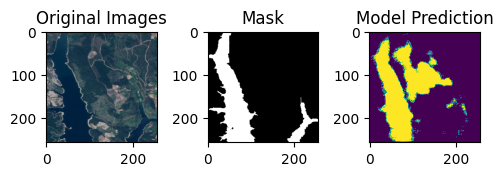

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

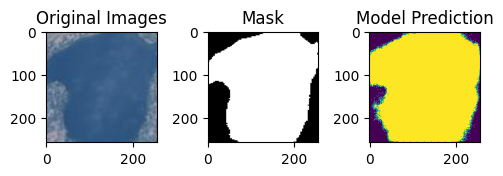

Epoch: 11/30
  Train - Total: 0.3286, Dice: 0.2855, BCE: 0.3574
  Val   - Total: 0.3582, Dice: 0.2860, BCE: 0.4063
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12/30
  Train - Total: 0.3238, Dice: 0.2809, BCE: 0.3524
  Val   - Total: 0.4172, Dice: 0.3058, BCE: 0.4915
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13/30
  Train - Total: 0.3241, Dice: 0.2790, BCE: 0.3542
  Val   - Total: 0.4695, Dice: 0.3261, BCE: 0.5651
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14/30
  Train - Total: 0.3213, Dice: 0.2780, BCE: 0.3501
  Val   - Total: 0.4690, Dice: 0.3198, BCE: 0.5686
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15/30
  Train - Total: 0.3254, Dice: 0.2806, BCE: 0.3553
  Val   - Total: 0.6370, Dice: 0.3596, BCE: 0.8219
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

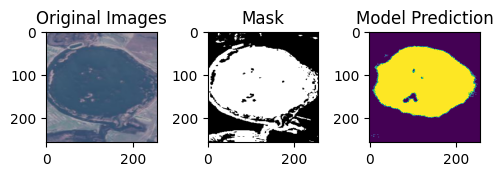

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

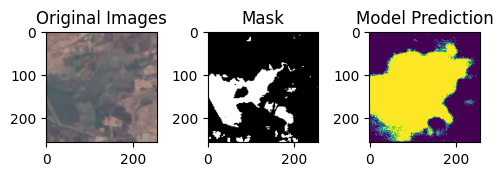

Epoch: 16/30
  Train - Total: 0.3238, Dice: 0.2797, BCE: 0.3531
  Val   - Total: 0.5306, Dice: 0.3353, BCE: 0.6607
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17/30
  Train - Total: 0.3231, Dice: 0.2777, BCE: 0.3534
  Val   - Total: 0.4583, Dice: 0.3109, BCE: 0.5567
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 19/30
  Train - Total: 0.3179, Dice: 0.2738, BCE: 0.3473
  Val   - Total: 0.4637, Dice: 0.3091, BCE: 0.5668
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 20/30
  Train - Total: 0.3204, Dice: 0.2745, BCE: 0.3510
  Val   - Total: 0.3773, Dice: 0.2903, BCE: 0.4353
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

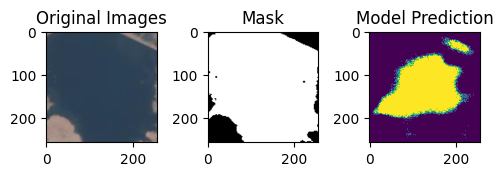

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

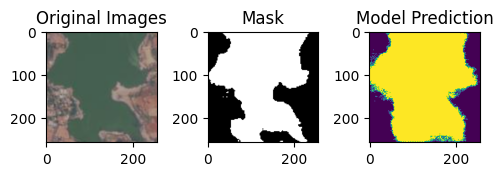

Epoch: 21/30
  Train - Total: 0.3179, Dice: 0.2723, BCE: 0.3483
  Val   - Total: 0.4173, Dice: 0.3060, BCE: 0.4915
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 22/30
  Train - Total: 0.3180, Dice: 0.2745, BCE: 0.3470
  Val   - Total: 0.4449, Dice: 0.3110, BCE: 0.5341
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 23/30
  Train - Total: 0.3161, Dice: 0.2728, BCE: 0.3451
  Val   - Total: 0.5086, Dice: 0.3269, BCE: 0.6296
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 24/30
  Train - Total: 0.3194, Dice: 0.2745, BCE: 0.3493
  Val   - Total: 0.4552, Dice: 0.3192, BCE: 0.5459
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 25/30
  Train - Total: 0.3167, Dice: 0.2731, BCE: 0.3458
  Val   - Total: 0.5419, Dice: 0.3379, BCE: 0.6779
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

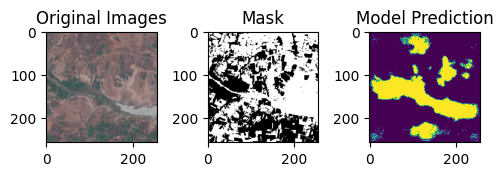

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

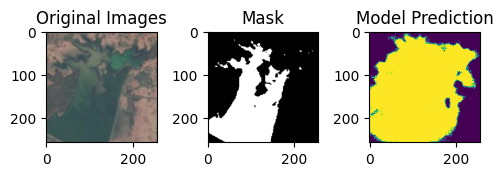

Epoch: 26/30
  Train - Total: 0.3188, Dice: 0.2746, BCE: 0.3482
  Val   - Total: 0.4735, Dice: 0.3211, BCE: 0.5751
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 27/30
  Train - Total: 0.3165, Dice: 0.2720, BCE: 0.3462
  Val   - Total: 0.5173, Dice: 0.3341, BCE: 0.6394
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 28/30
  Train - Total: 0.3164, Dice: 0.2716, BCE: 0.3463
  Val   - Total: 0.4539, Dice: 0.3194, BCE: 0.5435
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 29/30
  Train - Total: 0.3175, Dice: 0.2738, BCE: 0.3467
  Val   - Total: 0.4575, Dice: 0.3202, BCE: 0.5491
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 30/30
  Train - Total: 0.3170, Dice: 0.2729, BCE: 0.3464
  Val   - Total: 0.4715, Dice: 0.3181, BCE: 0.5737
--------------------------------------------------------------------------------


In [24]:
model2 = UNet(3,1)
model2 = nn.DataParallel(model2)
model2.to(device)

# using he initialisation to help with vanishing gradient
def he_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif isinstance(layer, nn.BatchNorm2d):
        nn.init.constant_(layer.weight, 1)
        nn.init.constant_(layer.bias, 0)

model2.apply(he_init)
epochs = 30

optimizer = torch.optim.AdamW(model2.parameters(), lr=0.00001, weight_decay=1e-3)
# optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001, weight_decay=1e-3)
# changed from 0.001 as it had shown some slower

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1 )

criterion = CombinedLoss()


train_losses_list, val_losses_list = train(model2, train_loader, test_loader, optimizer,criterion,epochs,scheduler)

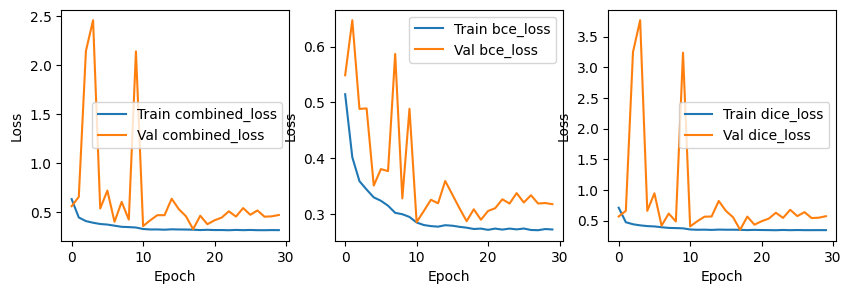

In [25]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
ax= axs.flatten()
i=0
for train_losses,val_losses, label in zip (train_losses_list, val_losses_list,['combined_loss','bce_loss','dice_loss']):
    ax[i].plot(np.arange(epochs), train_losses)
    ax[i].plot(np.arange(epochs), val_losses)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend([f"Train {label}", f"Val {label}"])
    i+=1
plt.show()

In [ ]:
torch.save(model2.state_dict(), 'vanilla_unet_model.pth')
torch.cuda.empty_cache()

In [ ]:
### 4.1 Model Evaluation
#### 4.1.1 Performance Evaluation
The model is evaluated on the validation set using the same loss function and metrics used during training.
The combined training loss is around 0.3170, with Dice loss and BCE loss being 0.2729 and 0.3464 respectively.
The combined validation loss is around 0.4715 with Dice loss and BCE loss being 0.3181 and BCE: 0.5737 respectively.
The loss convergence is shown in the plot above and stablized after 10 epochs.


#### 4.1.2 Error Analysis
# run one epoch and rank the errors

### In the next step , we will go from Vanialla Unet to U-Net++ architectures with EfficientNet encoder to check for any imrpovement in the model performance.

In [ ]:
# try replacing all the conv block in decoder to see if it helps 